In this project, we will use LSTM to build a neural network for time series forecasting.

We will work on the problem of forecasting the number of international airline passengers.

The task is to predict the number of international airline passengers in units of 1,000 based on a given year and month. The data spans the period from January 1949 to December 1960, covering 12 years with 144 observations.

This is a regression problem. By knowing the number of passengers (in thousands) for the previous months, we can predict the number of passengers for the next month. The dataset has only one feature: “Number of Passengers” - Passengers.

In [ ]:
!pip install torch
!pip install scikit-learn scipy matplotlib

In [8]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from sklearn.metrics import mean_squared_error
from  matplotlib import pyplot as plt

In [9]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

# Download data
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
df = pd.read_csv(url)
df.set_index('Month', inplace=True)
display(df.head())

,Passengers
Month,
1949-01,112
1949-02,118
1949-03,132
1949-04,129
1949-05,121


**Task 1.** Create a variable of type numpy.ndarray that contains the passenger count values in float32 format. This data format is necessary for training the neural network.

In [10]:
passengers = df.Passengers.astype('float32').to_numpy()
print(passengers)

[112. 118. 132. 129. 121. 135. 148. 148. 136. 119. 104. 118. 115. 126.
 141. 135. 125. 149. 170. 170. 158. 133. 114. 140. 145. 150. 178. 163.
 172. 178. 199. 199. 184. 162. 146. 166. 171. 180. 193. 181. 183. 218.
 230. 242. 209. 191. 172. 194. 196. 196. 236. 235. 229. 243. 264. 272.
 237. 211. 180. 201. 204. 188. 235. 227. 234. 264. 302. 293. 259. 229.
 203. 229. 242. 233. 267. 269. 270. 315. 364. 347. 312. 274. 237. 278.
 284. 277. 317. 313. 318. 374. 413. 405. 355. 306. 271. 306. 315. 301.
 356. 348. 355. 422. 465. 467. 404. 347. 305. 336. 340. 318. 362. 348.
 363. 435. 491. 505. 404. 359. 310. 337. 360. 342. 406. 396. 420. 472.
 548. 559. 463. 407. 362. 405. 417. 391. 419. 461. 472. 535. 622. 606.
 508. 461. 390. 432.]


**Task 2**. Splitештп the data into training and validation sets in a ratio of 67% for training and 33% for validation. We are working with time series data; therefore, we train on the older data and validate on the newer data.

In [11]:
train_count = int(round(len(passengers)*0.67, 0))

In [12]:
train = passengers[:train_count]
test = passengers[train_count:]

In [13]:
len(train), len(test)

(96, 48)

**Task 3**.

We will implement the create_dataset function, which will transform a one-dimensional time series (dataset) into a format suitable for training a neural network.

The function takes two arguments:

	•	dataset — a NumPy array representing the time series,
	•	lookback — the number of previous steps that will be used for prediction.

The function return3 two PyTorch tensors:

	•	X — a feature set (the window of previous values),
	•	y — the target values (the steps following the window).

We will provide the data to the model in the following format::
`
tensor([[112.],
        [118.],
        [132.],
        [129.],
        [121.]])
`
In this case, the first dimension will represent the size of the input batch, and the second dimension will represent the size of the input data, which is 1 because there is only one value at the input each time.

We will predict the number of passengers for the next day based on the number of passengers from the previous day, so `lookback == 1`.

In [14]:
def create_dataset(dataset, lookback = 1):
    # Initialize lists to hold the input sequences (X) and target values (y)
    X, y = [], []
    
    # Loop over the dataset and create input sequences and corresponding targets
    for i in range(len(dataset) - lookback):
        X.append(dataset[i:(i + lookback)])
        y.append(dataset[(i + 1):(i + lookback + 1)])
    
    # Convert X and y to PyTorch tensors
    X = torch.tensor(np.array(X), dtype=torch.float32)
    y = torch.tensor(np.array(y), dtype=torch.float32)
    
    return X, y

In [15]:
lookback = 1
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([95, 1]) torch.Size([95, 1])
torch.Size([47, 1]) torch.Size([47, 1])


**Завдання 4**.

Using the  `torch.nn` we create class `AirModel`, which is a neural network for forecasting the number of passengers using LSTM.

1. **The class constructor** takes parameters `hidden_size`, `num_layers` and initialize the layers:
   - An LSTM layer with the following parameters:
     - `input_size` — each point of the time series is a separate input,
     - `hidden_size` — as specified in the class constructor,
     - `num_layers=1` — the number of LSTM layers specified in the class constructor,
     - `batch_first=True` — indicates that the first dimension is the batch size.
   - A linear layer (`nn.Linear`) to transform the LSTM output into a forecast of a single point.

2. **The forward method** performs the following actions:
   - Passes the input tensor through the LSTM layer and obtain the outputs (ignoring the hidden states).
   - Passes the LSTM output through the linear layer to get the final prediction.

We will create an object of the `AirModel` class with the parameter values `hidden_size=50`, `num_layers=1` and test the model’s performance on the input tensor `tensor([[112.]])`. At this stage, we need to ensure that the model can generate predictions with randomly initialized weights.

In [16]:
class AirModel(torch.nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(AirModel, self).__init__()
        self.hidden_dim = hidden_size
        self.layer_dim = num_layers
        self.lstm = torch.nn.LSTM(input_size, hidden_size, num_layers, batch_first = True)
        self.fc = torch.nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out)
        return out

In [17]:
air_model = AirModel(1, 50, 1)
test_data = torch.tensor(np.array([112]), dtype=torch.float32).unsqueeze(1)
test_data

tensor([[112.]])

In [18]:
air_model(test_data)

tensor([[0.3227]], grad_fn=<AddmmBackward0>)

**Task 5**.

We will create a DataLoader object for loading the data using the training samples `X_train` and `y_train`.  DataLoader meets the following requirements:

1. Use the `TensorDataset` class, to combine the feature tensors `X_train` and  target values `y_train`.
2. The data will be loaded in small batches of size 8 using the `batch_size` parameter.
3. Use the `shuffle=True` parameter to shuffle the data before each training epoch..


In [19]:
train_ds = TensorDataset(X_train, y_train)
data_loader = DataLoader(dataset=train_ds, batch_size=8, shuffle=True)
test_ds = TensorDataset(X_test, y_test)
data_loader_test = DataLoader(dataset=test_ds, batch_size=8, shuffle=True)

In [20]:
next(iter(data_loader))

[tensor([[277.],
         [193.],
         [121.],
         [163.],
         [302.],
         [284.],
         [234.],
         [148.]]),
 tensor([[317.],
         [181.],
         [135.],
         [172.],
         [293.],
         [277.],
         [264.],
         [148.]])]

**Task 6**.

1. We will implement the training of the neural network `AirModel` for time series forecasting using the Adam optimizer and the MSE (Mean Squared Error) loss function..
2. We will create a training loop for 2000 epochs, where in each epoch:
	-	Perform a training step for the model (forward pass, compute loss, backward pass, and update weights).
	-	Calculate the average loss for each batch of data and store it in a list called `losses`.
3. Every 100 epochs, we validate the model:
	-	Evaluate the model on the training and test data without updating the weights.
	-	Compute the root mean squared error (RMSE) for both the training and test datasets and print the results to the screen..
   

In [21]:
optimizer = torch.optim.Adam(air_model.parameters())
loss_fn = F.mse_loss

In [22]:
def train(model, data_loader, optimizer, loss_fn):
    lossSum = 0
    for X, y in data_loader:
        optimizer.zero_grad()
        output = model(X)
        loss = loss_fn(output, y)
        loss.backward()
        optimizer.step()
        lossSum += loss.item()
    return lossSum/len(data_loader)
    
def validate(model, data_loader):
    lossSum = 0
    with torch.no_grad():
        for X, y in data_loader:
            output = model(X)
            loss = mean_squared_error(output, y, squared=False)
            lossSum += loss
    return lossSum/len(data_loader)

In [23]:
num_epochs = 2000
losses = []
for i in range(num_epochs):   
    air_model.train()
    mse = train(air_model, data_loader, optimizer, loss_fn)
    losses.append(mse)
    if i % 100 == 0:
        air_model.eval()
        rmse_train = validate(air_model, data_loader)
        rmse_test = validate(air_model, data_loader_test)
        print(f'Epoch {i}: train RMSE {rmse_train}, test RMSE {rmse_test}')
    

Epoch 0: train RMSE 223.74285507202148, test RMSE 421.8088785807292
Epoch 100: train RMSE 180.38516489664713, test RMSE 376.00275166829425
Epoch 200: train RMSE 145.10284233093262, test RMSE 335.375727335612
Epoch 300: train RMSE 114.29212125142415, test RMSE 300.1472676595052
Epoch 400: train RMSE 91.62676938374837, test RMSE 270.5896962483724
Epoch 500: train RMSE 74.55192025502522, test RMSE 245.35860697428384
Epoch 600: train RMSE 53.37511173884074, test RMSE 215.29258728027344
Epoch 700: train RMSE 43.7944286664327, test RMSE 186.0445810953776
Epoch 800: train RMSE 35.31006534894308, test RMSE 166.93909962972006
Epoch 900: train RMSE 32.434616247812905, test RMSE 154.84982299804688
Epoch 1000: train RMSE 31.982078234354656, test RMSE 138.0397160847982
Epoch 1100: train RMSE 24.985144297281902, test RMSE 123.99397150675456
Epoch 1200: train RMSE 24.30263344446818, test RMSE 118.14790217081706
Epoch 1300: train RMSE 23.698057333628338, test RMSE 110.5257174173991
Epoch 1400: train R

**Task 7.** Plot the loss graph

In [25]:
air_model.eval()
t = air_model(X_train[0:5])

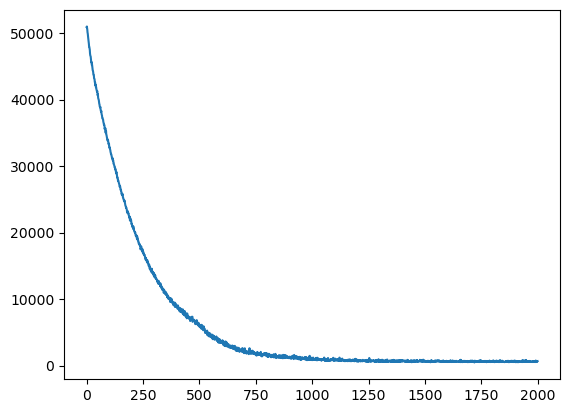

In [26]:
plt.plot(losses)

The model has learned, but it’s not certain that it’s accurate.

In [ ]:
timeseries = torch.tensor(np.array(passengers), dtype=torch.float32)
def plot_predicts(air_model):
  with torch.no_grad():
      # Shift predictions for training data
      train_plot = np.ones_like(timeseries) * np.nan
      y_pred = air_model(X_train)
      y_pred = y_pred[:, -1]
      train_plot[lookback:train_count] = air_model(X_train)[:, -1]

      # Shift predictions for test data
      test_plot = np.ones_like(timeseries) * np.nan
      test_plot[train_count+lookback:len(timeseries)] = air_model(X_test)[:, -1]

  # Visualization of results
  plt.plot(timeseries, c='b')  # Actual data
  plt.plot(train_plot, c='r')  # Predictions on training data
  plt.plot(test_plot, c='g')   # redictions on test data
  plt.show()

plot_predicts(air_model)

The shift of predictions for training and test data allows us to visually compare how well the model predicts on both the training and test sets. Typically, the red line (training predictions) should closely match the blue line (actual data), while the green line (test predictions) shows how well the model performs on new data that it has not seen before.

**Task 8**. Lets's build model with hidden_size=100 and compare results

In [32]:
air_model_100 = AirModel(1, 100, 1)
num_epochs = 20000
losses_100 = []
optimizer_100 = torch.optim.Adam(air_model_100.parameters(), lr=0.001)
loss_fn_100 = F.mse_loss
for i in range(num_epochs):   
    air_model_100.train()
    mse = train(air_model_100, data_loader, optimizer_100, loss_fn_100)
    losses_100.append(mse)
    if i % 100 == 0:
        air_model_100.eval()
        rmse_train = validate(air_model_100, data_loader)
        rmse_test = validate(air_model_100, data_loader_test)
        print(f'Epoch {i}: train RMSE {rmse_train}, test RMSE {rmse_test}')

Epoch 0: train RMSE 225.26438522338867, test RMSE 419.8578389485677
Epoch 100: train RMSE 130.1850153605143, test RMSE 320.629633585612
Epoch 200: train RMSE 81.23304557800293, test RMSE 258.5445073445638
Epoch 300: train RMSE 51.79187289873759, test RMSE 211.4574228922526
Epoch 400: train RMSE 38.277294635772705, test RMSE 178.4567667643229
Epoch 500: train RMSE 30.213857650756836, test RMSE 146.4240926106771
Epoch 600: train RMSE 26.30293329556783, test RMSE 128.87952931722006
Epoch 700: train RMSE 24.224491278330486, test RMSE 111.26810201009114
Epoch 800: train RMSE 25.717039227485657, test RMSE 108.40205001831055
Epoch 900: train RMSE 25.102402687072754, test RMSE 99.35118611653645
Epoch 1000: train RMSE 24.881570895512898, test RMSE 96.23900985717773
Epoch 1100: train RMSE 22.081539789835613, test RMSE 87.39813486735027
Epoch 1200: train RMSE 24.2040376663208, test RMSE 94.12959416707356
Epoch 1300: train RMSE 23.421221653620403, test RMSE 94.14175160725911
Epoch 1400: train RMSE

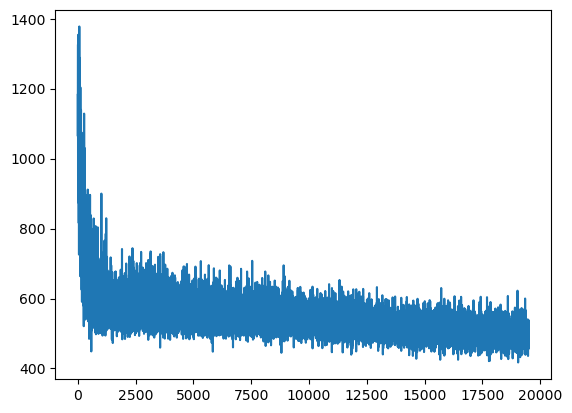

In [35]:
plt.plot(losses_100[500:])

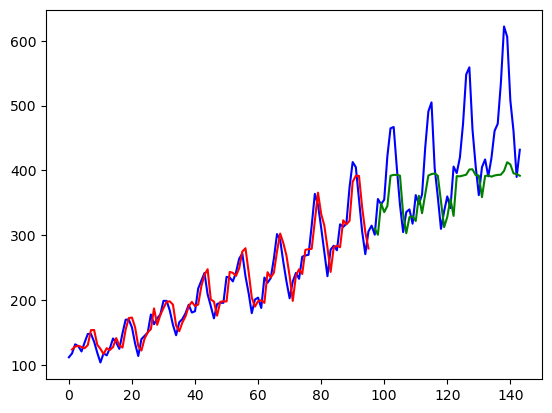

In [36]:
plot_predicts(air_model_100)

By increasing the number of training epochs and decreasing the learning rate, some improvement in results was achieved.